# Demo For text to image generation using CLIP VQDiffusion 

In [1]:

import os
import sys
import torch
import cv2
import argparse
import numpy as np
import torchvision
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from einops import einsum 
from image_synthesis.utils.io import load_yaml_config
from image_synthesis.modeling.build import build_model
from image_synthesis.utils.misc import get_model_parameters_info, instantiate_from_config

class CLIPVQDiffusion():
    def __init__(self, config, path, imagenet_cf=False):
        self.info = self.get_model(ema=True, model_path=path, config_path=config)
        self.model = self.info['model']
        self.tokenizer = self.info['tokenizer']
        self.model = self.model.cuda()
        self.model.eval()
        for param in self.model.parameters(): 
            param.requires_grad=False
        self.cos_sim=list()
        self.total_cnt=0

    def get_model(self, ema, model_path, config_path):
        if 'OUTPUT' in model_path: # pretrained model
            model_name = model_path.split(os.path.sep)[-3]
        else: 
            model_name = os.path.basename(config_path).replace('.yaml', '')
            
        config = load_yaml_config(config_path)
        model = build_model(config)
        tokenizer = instantiate_from_config(config["dataloader"]["validation_datasets"][0]["params"]["tokenize_config"])
        
        if os.path.exists(model_path):
            ema_model = model.get_ema_model()
            model_ckpt = torch.load(model_path)
            missing, unexpected = ema_model.load_state_dict(model_ckpt)#, strict=False)
        else:
            print("Model path: {} does not exist.".format(model_path))
            exit(0)
        
        return {'model': model, 'tokenizer':tokenizer}

    def inference_generate_sample_with_condition(self, data, truncation_rate, batch_size, guidance_scale=1.0, prior_rule=0, prior_weight=0, learnable_cf=True):
        self.model.guidance_scale = guidance_scale
        self.model.learnable_cf = self.model.transformer.learnable_cf = learnable_cf # whether to use learnable classifier-free
        self.model.transformer.prior_rule = prior_rule      # inference rule: 0 for VQ-Diffusion v1, 1 for only high-quality inference, 2 for purity prior
        self.model.transformer.prior_weight = prior_weight  # probability adjust parameter, 'r' in Equation.11 of Improved VQ-Diffusion

        # to device 
        data['text']['token'] = data['text']['token'].squeeze(1).to(self.model.device)
        data['text']['mask'] = data['text']['mask'].to(self.model.device)
        
        add_string = 'r'
        with torch.no_grad():
            model_out = self.model.generate_content(
            batch=data,
            filter_ratio=0,
            replicate=batch_size,
            content_ratio=1,
            return_att_weight=False,
            sample_type="top"+str(truncation_rate)+add_string,
            ) # B x C x H x W

        # save results
        content = model_out['content']
        clip_text_embedding = self.model.condition_codec.encode_text(data["text"]["token"])
        clip_img_embedding = self.model.condition_codec.encode_image(self.model.clip_img_preprocess(torchvision.transforms.Resize(224)((content/255))))
        
        clipscore = einsum(clip_text_embedding, clip_img_embedding, "b d, b d -> b")
        print(f'clip_score:{clipscore}')
        return content 

In [2]:
# hyper parameter and model setting 

# FFHQ setting 
CONFIG_PATH = "./configs/ffhq_finetune.yaml" 
MODEL_PATH = f"./OUTPUT/pretrained_model/diffusion_models/clipvq_ffhq.pt"
TRUNCATION_RATE = 0.85
SAVE_ROOT = f"./result/ffhq_tune_test2/0.5"
TIMES = 16 # repetition time
GUIDANCE_SCALE= 1.15
PRIOR_RULE=0 
PRIOR_WEIGHT=0 
LEARNABLE_CF=True

# COCO setting 
# CONFIG_PATH = "./configs/coco_finetune.yaml" 
# MODEL_PATH = f"./OUTPUT/pretrained_model/diffusion_models/clipvq_coco.pt"
# TRUNCATION_RATE = 0.9
# SAVE_ROOT = f"./result/coco_tune_test2/0.25"
# TIMES = 1 # repetition time
# GUIDANCE_SCALE= 3
# PRIOR_RULE=0 
# PRIOR_WEIGHT=0 
# LEARNABLE_CF=True


config = load_yaml_config(CONFIG_PATH)
diff_model = CLIPVQDiffusion(config=CONFIG_PATH, path=MODEL_PATH)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


clip_score:tensor([0.3635], device='cuda:0')


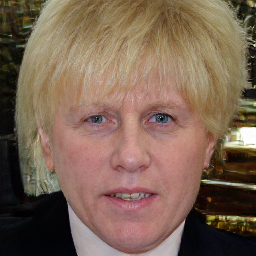

In [12]:
# generate image 

text = "a photograph of Prime Minister Boris Johnson"
data=dict()
data['text'] = diff_model.tokenizer.get_tokens(text)
image = diff_model.inference_generate_sample_with_condition(data=data, 
                                                            truncation_rate=TRUNCATION_RATE, 
                                                            batch_size=TIMES,  
                                                            guidance_scale=GUIDANCE_SCALE, 
                                                            prior_rule=PRIOR_RULE, 
                                                            prior_weight=PRIOR_WEIGHT, 
                                                            learnable_cf=LEARNABLE_CF)
img = to_pil_image(image[0]/255)
img